In [1]:
using Pkg
Pkg.activate(".")
Pkg.status()

  Activating project at `c:\Users\jonas\OneDrive\Desktop\Physics-Informed-Regression\scripts`


Status `C:\Users\jonas\OneDrive\Desktop\Physics-Informed-Regression\scripts\Project.toml` (empty project)


In [2]:
using ModelingToolkit
using DifferentialEquations
#using Interpolations
using PhysicsInformedRegression

# Lotka-Volterra model for predator-prey dynamics
The Lotka-Volterra equations describe the dynamics of predator-prey interactions in an ecosystem. The model consists of two differential equations that represent the growth of prey and the growth of predators based on the availability of prey.

$$
\begin{align*}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} &= \delta xy - \gamma y
\end{align*}
$$

Where: 
- $x$ is the prey population (e.g., rabbits)
- $y$ is the predator population (e.g., foxes)
- $\alpha$ is the growth rate of prey
- $\beta$ is the rate of predation (how many prey are consumed by predators)
- $\delta$ is the growth rate of predators per prey consumed
- $\gamma$ is the natural death rate of predators


## Model setup in Julia
In julia we choose to use the ([DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package) to represent the Lotka-Volterra model. The following defined the symbolic parameters and the system of equations.

In [3]:

## LOTKA VOLTERA
@parameters α β γ δ
@variables t x(t) y(t)
D = Differential(t)
eqs = [D(x) ~ α*x - β*x*y,
    D(y) ~ -γ*y + δ*x*y]


# Define the system
@named sys = ODESystem(eqs, t)
sys = complete(sys)

┌ Warning: Independent variable t should be defined with @independent_variables t.
└ @ ModelingToolkit C:\Users\jonas\.julia\packages\ModelingToolkit\AtpOX\src\utils.jl:119


Model sys:
Equations (2):
  2 standard: see equations(sys)
Unknowns (2): see unknowns(sys)
  x(t)
  y(t)
Parameters (4): see parameters(sys)
  α
  β
  δ
  γ

# Simulation setup
We choose the following parameters for the simulation:

* $\alpha = 1.5$  # Growth rate of prey
* $\beta = 1.0$  # Rate of predation
* $\delta = 3.0$  # Growth rate of predators per prey consumed
* $\gamma = 1.0$  # Natural death rate of predators

aswell as the initial conditions:
* $x_0 = 1,0$  # Initial prey population
* $y_0 = 0.5$  # Initial predator population

And simulate the system over a time span of $t = 0$ to $t = 10$ with $1000$ uniform time steps.


In [4]:
# Define the initial conditions and parameters
u0 = [x => 1.0,
    y => 1.0]

p = [α => 1.5,
    β => 1.0,
    γ => 3.0,
    δ => 1.0]

# Define the time span
start = 0; stop = 10; len = 1000 
timesteps = collect(range(start, stop, length = len))

# Simulate the system
prob = ODEProblem(sys, u0,(timesteps[1], timesteps[end]) ,p, saveat = timesteps)
sol = solve(prob)

# Compute the derivatives
du_approx =  PhysicsInformedRegression.finite_diff(sol.u, sol.t)


1000-element Vector{Vector{Float64}}:
 [0.5112381874128863, -1.9776228698845326]
 [0.5224347641758899, -1.9555359683624036]
 [0.544770299222013, -1.9117934089157502]
 [0.5669969939682518, -1.8689078709411246]
 [0.5891276417343844, -1.8268684229921368]
 [0.6111750358401781, -1.785664133622359]
 [0.6331519696053888, -1.7452840713853681]
 [0.6550710266821459, -1.7057172462236139]
 [0.6769409146883476, -1.6669513295157519]
 [0.6987740399494595, -1.6289742728844967]
 ⋮
 [0.43413777175317, -2.134698389544061]
 [0.4570762935001725, -2.087499384071721]
 [0.47983278403044965, -2.041199272566464]
 [0.5024271225754754, -1.9957983798960703]
 [0.5248791883666846, -1.9512970309281146]
 [0.5472088606354291, -1.9076955505300102]
 [0.5694360186130439, -1.8649942635691983]
 [0.5915805415311196, -1.8231934949136859]
 [0.6026346291292353, -1.802518280770791]

In [5]:
paramsest = PhysicsInformedRegression.physics_informed_regression(sys, sol.u, du_approx)

#compare the estimated parameters to the true parameters
parameterdict = Dict(p)
for (i, param) in enumerate(parameters(sys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
end

Parameter α = 1.5 estimated as 1.4989786445123154
Parameter β = 1.0 estimated as 0.9991910254495247
Parameter δ = 1.0 estimated as 0.9993764018998466
Parameter γ = 3.0 estimated as 2.999430028234534


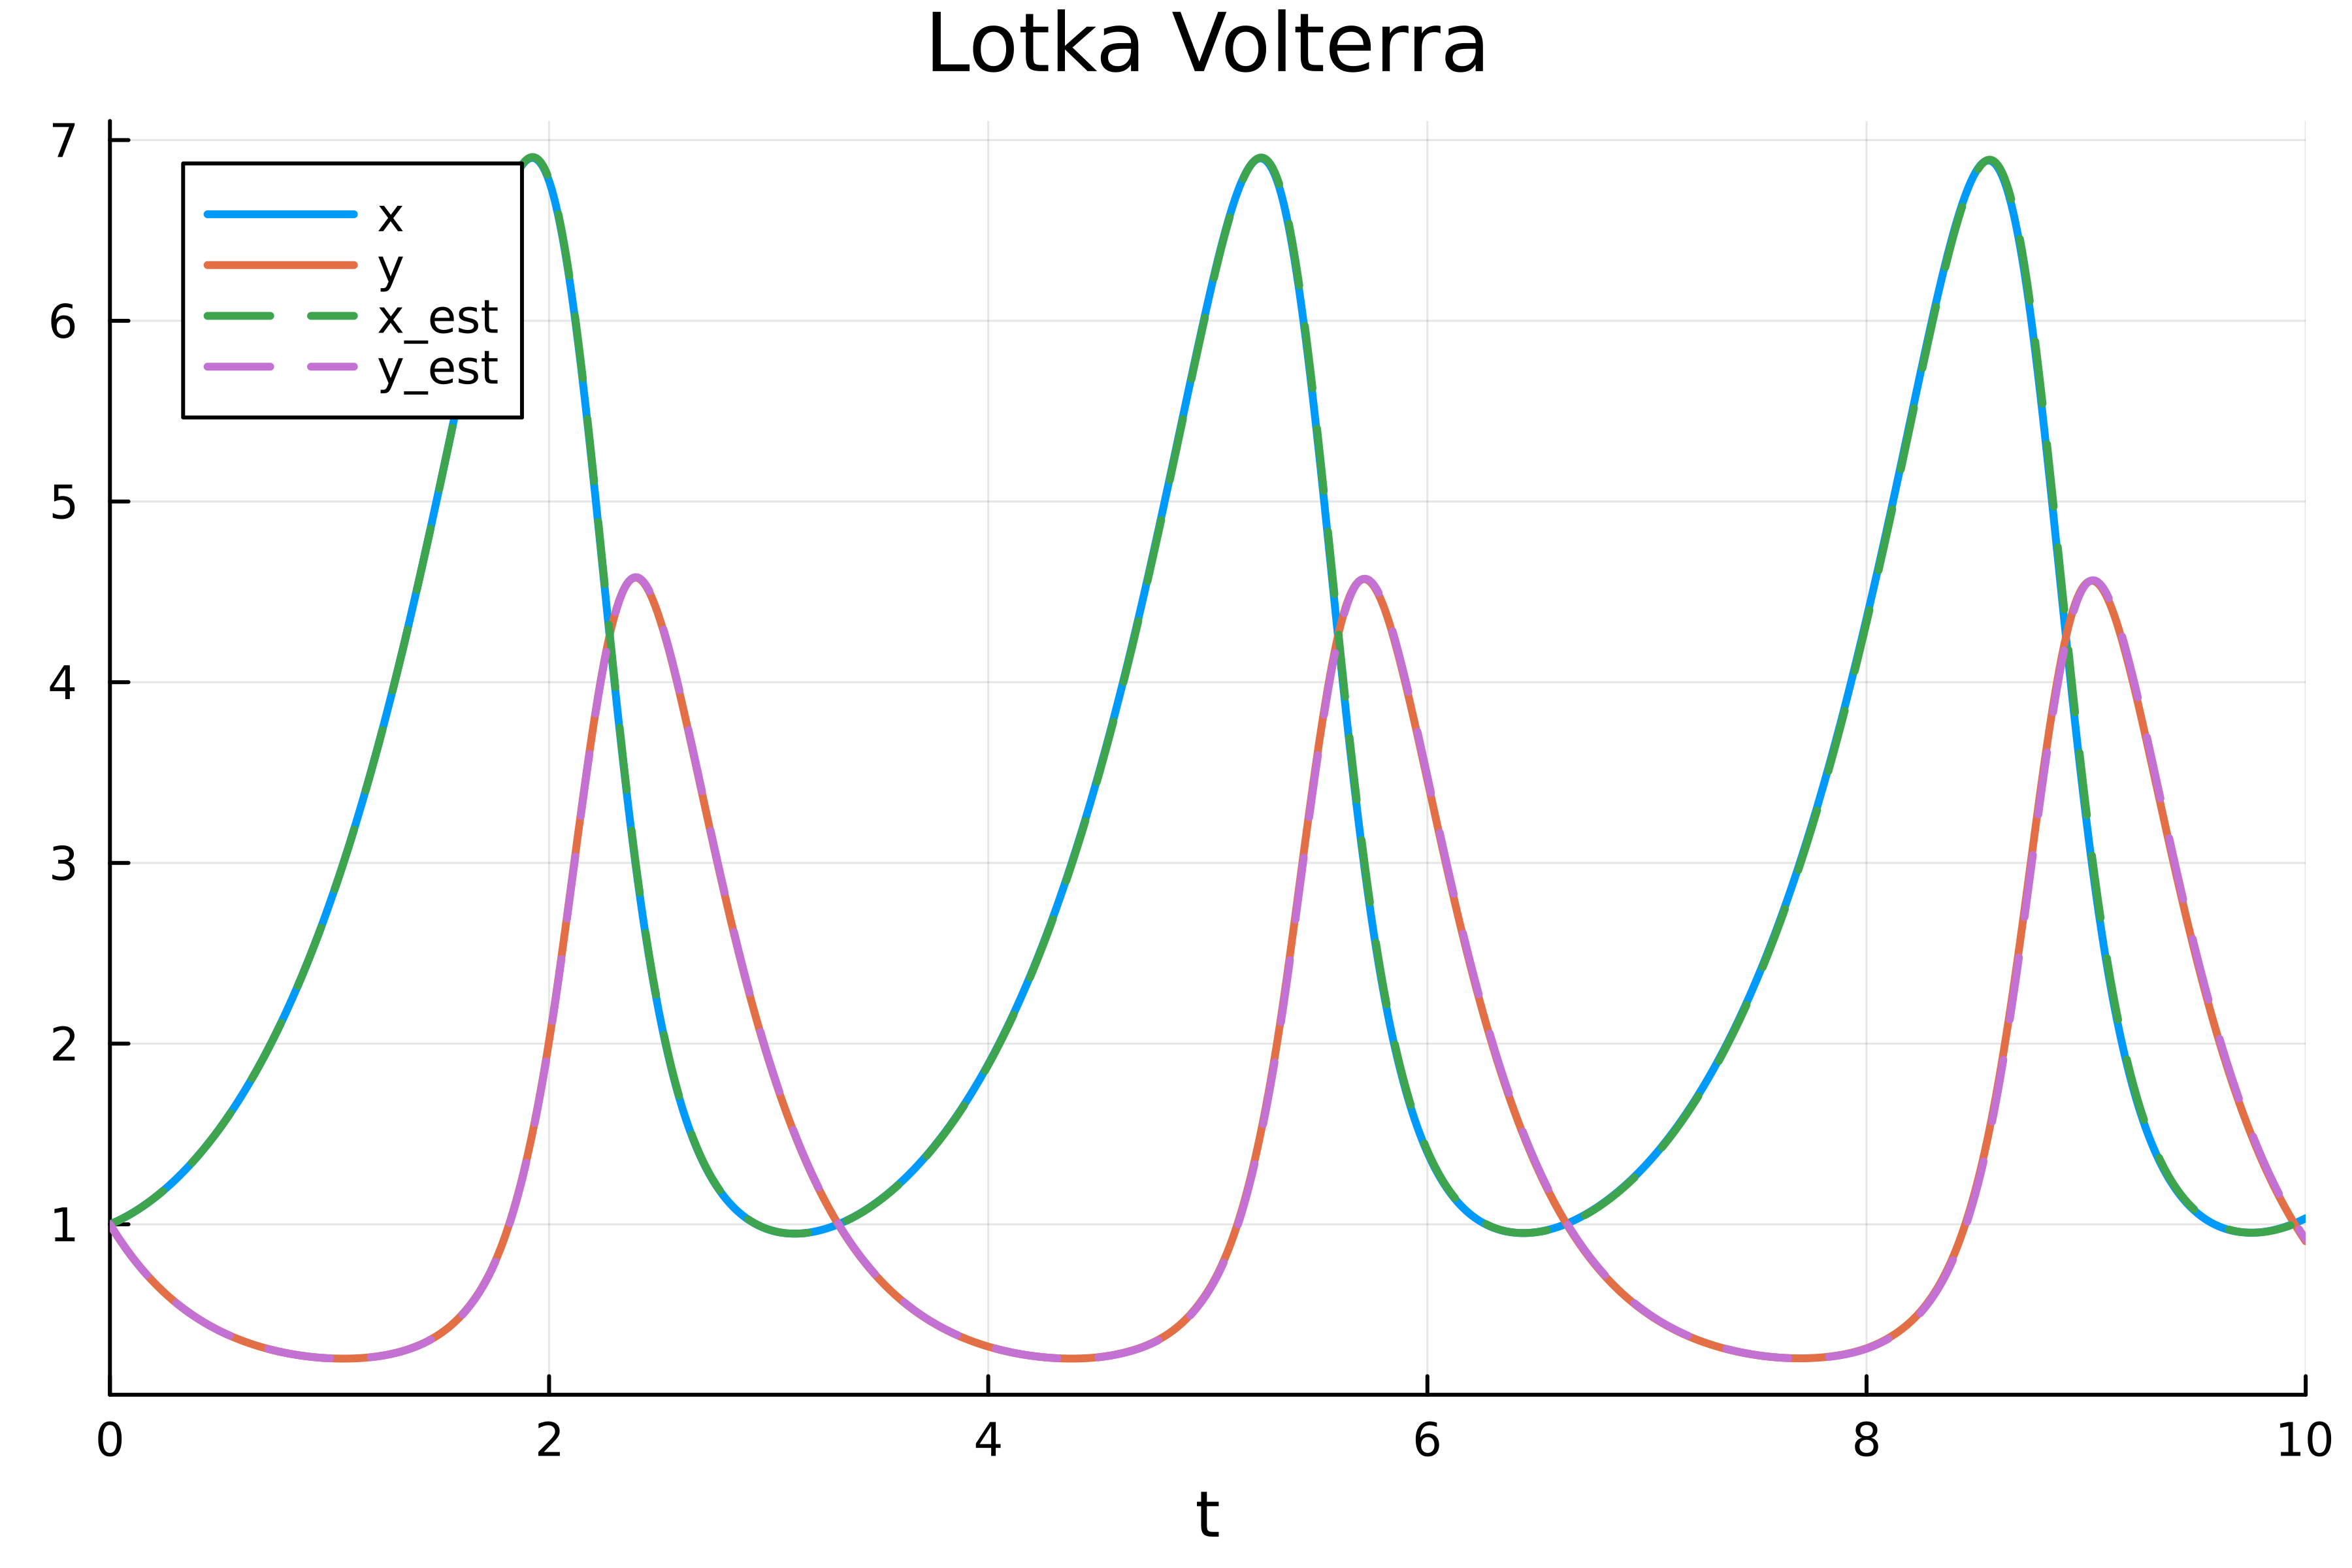

In [6]:
# Plot the results
using Plots
estimated_sol = solve(ODEProblem(sys, u0,(start, stop) ,paramsest), Tsit5(), saveat = timesteps)
plot(sol, label = ["x" "y"], title = "Lotka Volterra", lw = 2, dpi = 600)
plot!(estimated_sol, label = ["x_est" "y_est"], lw = 2, ls = :dash, dpi = 600)

## Number of datapoints vs. noise

In [9]:
include("../utils/julia_utils.jl")

noise_vals = [0.0, 0.01, 0.05, 0.1]
n_data_points = [5, 10, 50, 100]
n_iter = 20

parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points, n_iter, p)

table = create_table(parameter_estimates)

MethodError: MethodError: no method matching noise_v_collocation_points(::ODESystem, ::ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Nothing, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Base.Pairs{Symbol, Vector{Float64}, Tuple{Symbol}, @NamedTuple{saveat::Vector{Float64}}}, SciMLBase.StandardODEProblem}, CompositeAlgorithm{0, Tuple{Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Vern7{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Rosenbrock23{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, Rodas5P{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, FBDF{5, 0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, Nothing, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!)}, FBDF{5, 0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, KrylovJL{typeof(Krylov.gmres!), Int64, Nothing, Tuple{}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, Nothing, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!)}}, OrdinaryDiffEqCore.AutoSwitchCache{Tuple{Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Vern7{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}}, Tuple{Rosenbrock23{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, Rodas5P{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, FBDF{5, 0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, Nothing, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!)}, FBDF{5, 0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, KrylovJL{typeof(Krylov.gmres!), Int64, Nothing, Tuple{}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, Nothing, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!)}}, Rational{Int64}, Int64}}, OrdinaryDiffEqCore.InterpolationData{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Vector{Int64}, OrdinaryDiffEqCore.DefaultCache{OrdinaryDiffEqTsit5.Tsit5Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqVerner.Vern7Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqRosenbrock.Rosenbrock23Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, OrdinaryDiffEqRosenbrock.Rosenbrock23Tableau{Float64}, SciMLBase.TimeGradientWrapper{true, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}}, SciMLBase.UJacobianWrapper{true, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Float64, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LinearSolve.DefaultLinearSolver, LinearSolve.DefaultLinearSolverInit{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Vector{Int64}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Vector{Int64}}, Nothing, Nothing, Nothing, LinearAlgebra.SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int32}}, Base.RefValue{Int32}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Base.RefValue{Int64}}, LinearAlgebra.QRPivoted{Float64, Matrix{Float64}, Vector{Float64}, Vector{Int64}}, Nothing, Nothing}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Bool, LinearSolveAdjoint{Missing}}, Tuple{DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgJacobianPrep{Nothing, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, Float64, Float64, Int64}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgJacobianPrep{Nothing, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, Float64, Float64, Int64}}, Tuple{DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgDerivativePrep{Nothing, FiniteDiff.GradientCache{Nothing, Vector{Float64}, Vector{Float64}, Float64, Val{:forward}(), Float64, Val{true}()}, Float64, Float64, Int64}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgDerivativePrep{Nothing, FiniteDiff.GradientCache{Nothing, Vector{Float64}, Vector{Float64}, Float64, Val{:forward}(), Float64, Val{true}()}, Float64, Float64, Int64}}, Float64, Rosenbrock23{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, OrdinaryDiffEqRosenbrock.RosenbrockCache{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, OrdinaryDiffEqRosenbrock.RodasTableau{Float64, Float64}, SciMLBase.TimeGradientWrapper{true, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}}, SciMLBase.UJacobianWrapper{true, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Float64, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LinearSolve.DefaultLinearSolver, LinearSolve.DefaultLinearSolverInit{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Vector{Int64}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Vector{Int64}}, Nothing, Nothing, Nothing, LinearAlgebra.SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int32}}, Base.RefValue{Int32}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Base.RefValue{Int64}}, LinearAlgebra.QRPivoted{Float64, Matrix{Float64}, Vector{Float64}, Vector{Int64}}, Nothing, Nothing}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Bool, LinearSolveAdjoint{Missing}}, Tuple{DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgJacobianPrep{Nothing, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, Float64, Float64, Int64}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgJacobianPrep{Nothing, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, Float64, Float64, Int64}}, Tuple{DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgDerivativePrep{Nothing, FiniteDiff.GradientCache{Nothing, Vector{Float64}, Vector{Float64}, Float64, Val{:forward}(), Float64, Val{true}()}, Float64, Float64, Int64}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgDerivativePrep{Nothing, FiniteDiff.GradientCache{Nothing, Vector{Float64}, Vector{Float64}, Float64, Val{:forward}(), Float64, Val{true}()}, Float64, Float64, Int64}}, Float64, Rodas5P{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, OrdinaryDiffEqBDF.FBDFCache{5, OrdinaryDiffEqNonlinearSolve.NLSolver{NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, true, Vector{Float64}, Float64, Nothing, Float64, OrdinaryDiffEqNonlinearSolve.NLNewtonCache{Vector{Float64}, Float64, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, SciMLBase.UJacobianWrapper{true, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Float64, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}}, Tuple{DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgJacobianPrep{Nothing, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, Float64, Float64, Int64}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgJacobianPrep{Nothing, FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}, Float64, Float64, Int64}}, LinearSolve.LinearCache{Matrix{Float64}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, LinearSolve.DefaultLinearSolver, LinearSolve.DefaultLinearSolverInit{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Vector{Int64}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Vector{Int64}}, Nothing, Nothing, Nothing, LinearAlgebra.SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int32}}, Base.RefValue{Int32}}, Tuple{LinearAlgebra.LU{Float64, Matrix{Float64}, Vector{Int64}}, Base.RefValue{Int64}}, LinearAlgebra.QRPivoted{Float64, Matrix{Float64}, Vector{Float64}, Vector{Int64}}, Nothing, Nothing}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Bool, LinearSolveAdjoint{Missing}}}, Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Matrix{Float64}, StaticArraysCore.SMatrix{5, 6, Rational{Int64}, 30}, Float64, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEqCore.trivial_limiter!)}, OrdinaryDiffEqBDF.FBDFCache{5, OrdinaryDiffEqNonlinearSolve.NLSolver{NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, true, Vector{Float64}, Float64, Nothing, Float64, OrdinaryDiffEqNonlinearSolve.NLNewtonCache{Vector{Float64}, Float64, Float64, Vector{Float64}, OrdinaryDiffEqDifferentiation.JVPCache{Float64, OrdinaryDiffEqDifferentiation.var"#9#10"{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgPushforwardPrep{Nothing, FiniteDiff.JVPCache{Vector{Float64}, Vector{Float64}, Val{:forward}()}, Float64, Float64, Bool}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}, OrdinaryDiffEqDifferentiation.WOperator{true, Any, LinearAlgebra.UniformScaling{Bool}, Float64, OrdinaryDiffEqDifferentiation.JVPCache{Float64, OrdinaryDiffEqDifferentiation.var"#9#10"{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgPushforwardPrep{Nothing, FiniteDiff.JVPCache{Vector{Float64}, Vector{Float64}, Val{:forward}()}, Float64, Float64, Bool}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}, Vector{Float64}, Nothing, OrdinaryDiffEqDifferentiation.JVPCache{Float64, OrdinaryDiffEqDifferentiation.var"#9#10"{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgPushforwardPrep{Nothing, FiniteDiff.JVPCache{Vector{Float64}, Vector{Float64}, Val{:forward}()}, Float64, Float64, Bool}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, SciMLBase.UJacobianWrapper{true, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Float64, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}}, Tuple{Nothing, Nothing}, LinearSolve.LinearCache{OrdinaryDiffEqDifferentiation.WOperator{true, Any, LinearAlgebra.UniformScaling{Bool}, Float64, OrdinaryDiffEqDifferentiation.JVPCache{Float64, OrdinaryDiffEqDifferentiation.var"#9#10"{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgPushforwardPrep{Nothing, FiniteDiff.JVPCache{Vector{Float64}, Vector{Float64}, Val{:forward}()}, Float64, Float64, Bool}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}, Vector{Float64}, Nothing, OrdinaryDiffEqDifferentiation.JVPCache{Float64, OrdinaryDiffEqDifferentiation.var"#9#10"{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, DifferentiationInterfaceFiniteDiffExt.FiniteDiffTwoArgPushforwardPrep{Nothing, FiniteDiff.JVPCache{Vector{Float64}, Vector{Float64}, Val{:forward}()}, Float64, Float64, Bool}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, KrylovJL{typeof(Krylov.gmres!), Int64, Nothing, Tuple{}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}, Krylov.GmresWorkspace{Float64, Float64, Vector{Float64}}, LinearSolve.InvPreconditioner{LinearAlgebra.Diagonal{Float64, Vector{Float64}}}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, Bool, LinearSolveAdjoint{Missing}}}, Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Matrix{Float64}, StaticArraysCore.SMatrix{5, 6, Rational{Int64}, 30}, Float64, Vector{Float64}, Vector{Float64}, typeof(OrdinaryDiffEqCore.trivial_limiter!)}, Tuple{Vector{Float64}, Vector{Float64}, DataType, DataType, DataType, Vector{Float64}, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}, false}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ODESystem}, Nothing, ODESystem, SciMLBase.OverrideInitData{NonlinearProblem{Nothing, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, NonlinearFunction{true, SciMLBase.FullSpecialize, ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x11264d91, 0x6f950810, 0x219b6f5c, 0xa116dce3, 0x0d2cf260), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xa91b7269, 0xc7362cbf, 0x1f7f3547, 0x18eb5bbe, 0x1926b244), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{NonlinearSystem}, Nothing, NonlinearSystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardNonlinearProblem}, typeof(ModelingToolkit.update_initializeprob!), ComposedFunction{typeof(identity), SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf443ed80, 0xff933f48, 0x16e8cf43, 0x08e444c3, 0x96de88e9), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xbbb8a0c2, 0xa1179e80, 0xd5f3506c, 0x23507192, 0x15355175), Nothing}}}}, ModelingToolkit.var"#initprobpmap_split#806"{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{Nothing, Tuple{SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x31adaae2, 0x7ed58beb, 0x18019956, 0xa37040fb, 0x67914fcc), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x4aca805c, 0x5f16854c, 0xf91512af, 0x6f7376d8, 0xfabb1ab2), Nothing}}}, SymbolicIndexingInterface.TimeIndependentObservedFunction{ModelingToolkit.GeneratedFunctionWrapper{(2, 2, true), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xdd7b2718, 0xb67c26d1, 0x91d0c0c3, 0xb699d070, 0x01e83b02), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :__mtk_arg_1, :___mtkparameters___), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x376668b2, 0x220ebc7d, 0x4b4d3830, 0xd2c3adfb, 0xd35d11b2), Nothing}}}, SymbolicIndexingInterface.MultipleGetters{Nothing, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}}}}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}}, ModelingToolkit.InitializationMetadata{ModelingToolkit.ReconstructInitializeprob{ModelingToolkit.var"#_getter#802"{Tuple{ComposedFunction{ModelingToolkit.PConstructorApplicator{typeof(identity)}, ComposedFunction{Base.Fix1{typeof(reduce), typeof(vcat)}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Tuple{SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Tunable, Int64}}}, Nothing}, SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicIndexingInterface.GetIndepvar}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}}}}, Returns{StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}}, Returns{Tuple{}}, Returns{Tuple{}}, Returns{Tuple{}}}}, ComposedFunction{typeof(identity), SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{Any}}}}, ModelingToolkit.GetUpdatedU0{SymbolicIndexingInterface.MultipleGetters{SymbolicIndexingInterface.ContinuousTimeseries, Vector{SymbolicUtils.BasicSymbolic{Real}}}, SymbolicIndexingInterface.MultipleParametersGetter{SymbolicIndexingInterface.IndexerNotTimeseries, Vector{SymbolicIndexingInterface.GetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}}, Nothing}}, ModelingToolkit.SetInitialUnknowns{SymbolicIndexingInterface.MultipleSetters{Vector{SymbolicIndexingInterface.ParameterHookWrapper{SymbolicIndexingInterface.SetParameterIndex{ModelingToolkit.ParameterIndex{SciMLStructures.Initials, Int64}}, SymbolicUtils.BasicSymbolic{Real}}}}}}, Val{true}}, Nothing}, Float64, Float64, Float64, MTKParameters{Vector{Float64}, Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, Bool, Val{true}}, OrdinaryDiffEqCore.AutoSwitchCache{Tuple{Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Vern7{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}}, Tuple{Rosenbrock23{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, Rodas5P{0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, FBDF{5, 0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, Nothing, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!)}, FBDF{5, 0, AutoFiniteDiff{Val{:forward}, Val{:forward}, Val{:hcentral}, Nothing, Nothing, Bool}, KrylovJL{typeof(Krylov.gmres!), Int64, Nothing, Tuple{}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Nothing}, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, Nothing, Nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!)}}, Rational{Int64}, Int64}, Vector{Float64}}, Nothing}, SciMLBase.DEStats, Vector{Int64}, Nothing, Nothing, Nothing}, ::Vector{Float64}, ::Vector{Int64}, ::Int64, ::Vector{Pair{Num, Float64}})
The function `noise_v_collocation_points` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  noise_v_collocation_points(::ODESystem, ::Union{Dict, ODESolution}, ::Vector{Float64}, ::Vector{Int64}, ::Int64, !Matched::Dict{Symbol, Float64})
   @ Main c:\Users\jonas\OneDrive\Desktop\Physics-Informed-Regression\utils\julia_utils.jl:15
  noise_v_collocation_points(::ODESystem, ::Union{Dict, ODESolution}, ::Vector{Float64}, ::Vector{Int64}, ::Int64)
   @ Main c:\Users\jonas\OneDrive\Desktop\Physics-Informed-Regression\utils\julia_utils.jl:15
  noise_v_collocation_points(::ODESystem, ::Union{Dict, ODESolution}, ::Vector{Float64}, ::Vector{Int64})
   @ Main c:\Users\jonas\OneDrive\Desktop\Physics-Informed-Regression\utils\julia_utils.jl:15
